In [2]:
import os
import sys
import glob as gb
import re
from pathlib import Path

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.style.use('classic')

import pydicom as dcm
import pylab

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

# General settings

In [3]:
# See https://stackoverflow.com/questions/14722540/smoothing-between-pixels-of-imagesc-imshow-in-matlab-like-the-matplotlib-imshow
mpl.rcParams['image.interpolation'] = 'none' # default 'bilinear'

layout=Layout(width='90%') # For ipywidgets

In [4]:
home = str(Path.home())
data_dir = f"{home}/data/aneurysm/"
PATH = Path(data_dir)
# STL
stl_dir = f"{home}/data/aneurysm/stls.ours/"

# Dicom
dcm_dir = f"{home}/data/aneurysm/ct-512/"
mask_dir = f"{home}/data/aneurysm/mask-512/"

# PNG
pngs_dir = f"{home}/data/aneurysm/train-512/"
masks_pngs_dir = f"{home}/data/aneurysm/train_masks-512/"

dirs = [data_dir,mask_dir,stl_dir,dcm_dir,pngs_dir,masks_pngs_dir]

In [51]:
# Pathes
HOME = Path.home()

DATA = HOME / 'data/aneurysm'
PATH = DATA

CT_DCM = DATA / 'ct-512'
MASK_DCM = DATA / 'mask-512'

CT_NP = DATA / 'ct-512-NP'
MASK_NP = DATA / 'mask-512-NP'

TRAIN_512 = CT_PNG
MASK_512 = MASK_PNG


# CT_128 = DATA / 'train-128'
# MASK_128 = DATA / 'train_masks-128'

# CT_128_NP = DATA / 'ct-128-NP'
# MASK_128_NP = DATA / 'mask-128-NP'

TMP = DATA / 'tmp'

CT_NP.mkdir(exist_ok=True)
MASK_NP.mkdir(exist_ok=True)

CT_PNG.mkdir(exist_ok=True)
MASK_PNG.mkdir(exist_ok=True)

In [52]:
# # for d in dirs:
# #      !mkdir -p {d}
# !tree --filelimit=21 {DATA}
# !pwd

In [53]:
#!ls -1 {pngs_dir} | wc -l 

# Data exploration

In [54]:
reg_complete_filename = re.compile("[^/]*$") # Match a file name in a path
reg_filename = re.compile("^([^.]+)") # Match a file name in a path

def get_filename(paths,num):
    complete_filename = re.search(reg_complete_filename, paths[num]).group(0)
    return re.search(reg_filename, complete_filename).group(0)
    
def get_dicoms_paths(source_dir):
    return sorted(gb.glob(f"{source_dir}*.dcm"))

In [55]:
def get_pngs(dicoms_paths,dcm_num):
    ds = dcm.read_file(dicoms_paths[dcm_num]) # get the dicom file #dcm_num
    return ds.pixel_array

# Shows one image
def browse_dicom(source_dir,dicom_num):
    dicoms_paths = get_dicoms_paths(source_dir)
    pngs = get_pngs(dicoms_paths,dicom_num)
    last = len(pngs)-1
    print(dicoms_paths[dicom_num])
    def show_png(num):
        pylab.imshow(pngs[num],cmap=pylab.cm.bone)
    interact(show_png, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout));

# Shows original and mask side by side
def browse_dicom_and_mask(original_dir,mask_dir,dicom_num):
    original_paths = get_dicoms_paths(original_dir)
    mask_paths = get_dicoms_paths(mask_dir)
    
    original_pngs = get_pngs(original_paths,dicom_num)
    mask_pngs = get_pngs(mask_paths,dicom_num)
    
    last = len(original_pngs)-1
    print(original_paths[dicom_num])
    print(mask_paths[dicom_num])
    def show_png(num):
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        pylab.imshow(original_pngs[num],cmap=pylab.cm.bone)
        f.add_subplot(1,2, 2)
        pylab.imshow(mask_pngs[num],cmap=pylab.cm.bone)
        plt.show(block=True)
    interact(show_png, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout))

In [56]:
browse_dicom_and_mask(dcm_dir,mask_dir,12)

/home/amer/data/aneurysm/ct-512/A029.dcm
/home/amer/data/aneurysm/mask-512/A029.mask.dcm


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=439), Output()), _…

In [57]:
browse_dicom(dcm_dir,1) # Show me the MRI Dicom file #2
browse_dicom(mask_dir,1) # Show me the Mask Dicom file #2

/home/amer/data/aneurysm/ct-512/A013.dcm


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=438), Output()), _…

/home/amer/data/aneurysm/mask-512/A013.mask.dcm


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=438), Output()), _…

In [58]:
def save_dicom_to_pngs(source_dir,target_dir,dicom_num):
    paths = get_dicoms_paths(source_dir)
    dicom_file_name = get_filename(paths,dicom_num)
    pngs = get_pngs(paths,dicom_num)
    slice_count = len(pngs)-1
    for i in range(dicom_num,slice_count):
        pylab.imsave(f"{target_dir}{dicom_file_name}_{i}",pngs[i],cmap=pylab.cm.bone)
    return slice_count+1

In [59]:
def breakup_dicom(source_dir,target_dir): # Dicom to pngs
    dicom_paths = get_dicoms_paths(source_dir) # Get dicoms files
    file_count = len(dicom_paths) # Count dicom files
    for i in range(0,file_count):
        print(f"Breaking up {get_filename(dicom_paths,i)} into pngs...")
        slice_num = save_dicom_to_pngs(source_dir,target_dir,i)
        print(f"Finished {get_filename(dicom_paths,i)}! {slice_num} slices were saved.\n")
    print(f"PNGs are in {pngs_dir}")

In [60]:
# breakup_dicom(dcm_dir,pngs_dir)

In [61]:
# breakup_dicom(mask_dir,masks_pngs_dir)

In [62]:
# return the dicom file as a numpy array
# @index is the index of the file in "dcm_dir" directory
def dicom_as_tensor(index):
    return get_pngs(get_dicoms_paths(dcm_dir),index)

def mask_as_tensor(index):
    return get_pngs(get_dicoms_paths(mask_dir),index)

In [63]:
def show_scaled_dicom(source_dir,dcm_index):
    dicoms_paths = get_dicoms_paths(source_dir)
    dcm = get_pngs(dicoms_paths,dcm_index)
    last = last = len(dcm)-1
    print(last)
    def show_img(num):
        _slice = dcm[num]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(_slice)
        scaled = scaler.transform(_slice)
        plt.figure(figsize=(8,8))
        pylab.imshow(scaled,cmap=pylab.cm.bone)
    interact(show_img, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout));

In [64]:
show_scaled_dicom(dcm_dir,6)

438


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=438), Output()), _…

In [65]:
tensor = dicom_as_tensor(3)[0]
# print(np.shape(tensor))
# w = 200 # window1
# m = 1 # stried
print(np.shape(tensor))
#print(tensor[m:m+w,m:m+w])
# plt.figure(figsize=(8,8))
# pylab.imshow(tensor,cmap=pylab.cm.bone)

(512, 512)


In [66]:
tensor = dicom_as_tensor(3)[0]
# Sliding window
def tensor_window(tensor):
    height = np.shape(tensor)[0]
    width = np.shape(tensor)[1]
    def move_window(x,y,w):
        print(np.shape(tensor))
        print(f'[x-w:x,y-w:y]: [{max([x-w,0])}:{x},{max([y-w,0])}:{y}]')
        wx = max([x-w,0])
        wy = max([y-w,0])
        print(f'Window= {w}x{w}')
        t = tensor[wx:x,wy:y]
        pylab.imshow(t,cmap=pylab.cm.bone)
    s = 1 # stried
    interact(move_window,
             x=widgets.IntSlider(min=40,max=height,step=s,layout=layout),
             y=widgets.IntSlider(min=40,max=width,step=s,layout=layout),
             w=widgets.IntSlider(min=40,max=512,step=1,layout=layout),)
    
    
tensor_window(tensor)

interactive(children=(IntSlider(value=40, description='x', layout=Layout(width='90%'), max=512, min=40), IntSl…

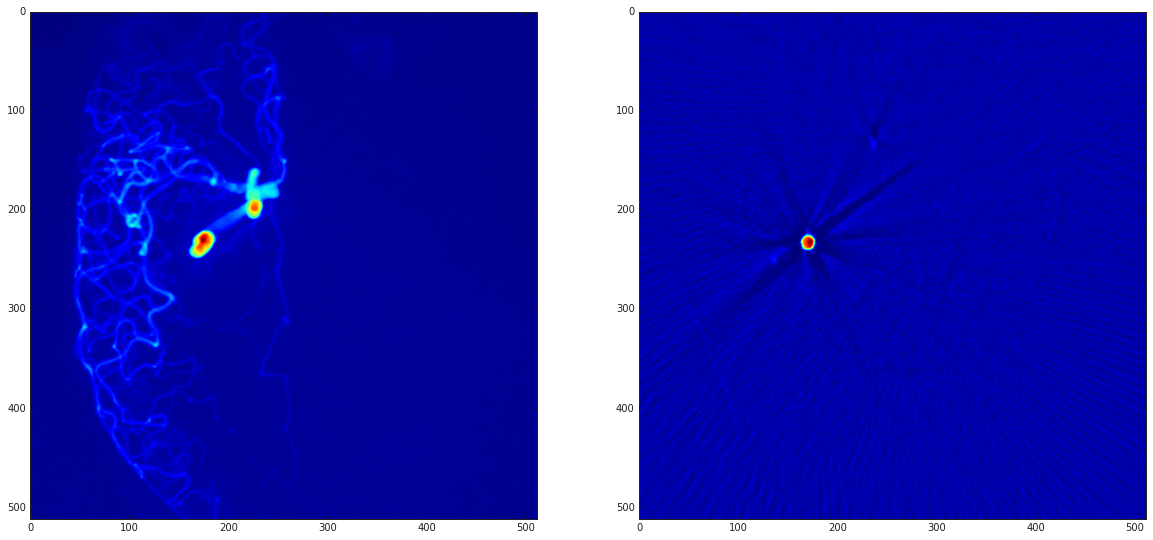

In [67]:
# Slices sum
img_id = 3
slice_index = 0 # First slice
slices_to_sum = 439 # Starting from the slice number slice_index

slice_ = np.std(dicom_as_tensor(img_id)[slice_index:slice_index+slices_to_sum],axis=0)

f = plt.figure(figsize=(20,10))
f.add_subplot(1,2, 1)
plt.imshow(slice_)
f.add_subplot(1,2, 2)
plt.imshow(dicom_as_tensor(3)[slice_index])

# The Deep Learning module

In [68]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [70]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

from pathlib import Path
import json
# torch.cuda.set_device(0)
# torch.backends.cudnn.benchmark=True


# Read and show PNG functions

/home/amer/data/aneurysm/ct-512-PNG/A015_195.png
/home/amer/data/aneurysm/mask-512-PNG/A015_195.png


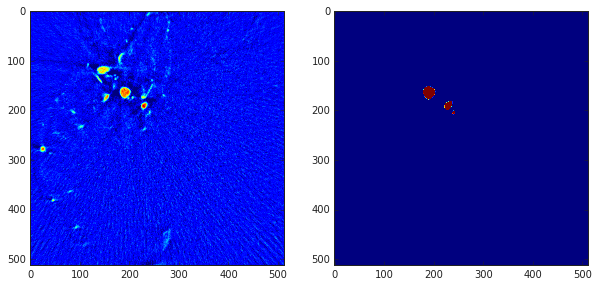

In [71]:
images = sorted(list(Path(TRAIN_512).iterdir()))
masks = sorted(list(Path(MASK_512).iterdir()))

img_id = 300

# @kind "I" for Images or "M" for masks
def get_path(index=0,kind="I"):
    if kind == "I":
        return str(images[index])
    else:
        return str(masks[index])

def read_png(index=0,kind="I"):
    if kind == "I":
        return mpimg.imread(get_path(index,kind="I"))
    else:
        return mpimg.imread(get_path(index,kind="M"))

def show_png(index=0,kind="I"):
    if kind == "I":
        plt.imshow(read_png(index,kind="I"))
    else:
        plt.imshow(read_png(index,kind="M"))


index = 985

print(get_path(index,kind="I"))
print(get_path(index,kind="M"))

f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
show_png(index=index,kind="I")
f.add_subplot(1,2, 2)
show_png(index=index,kind="M")

# Mask processing

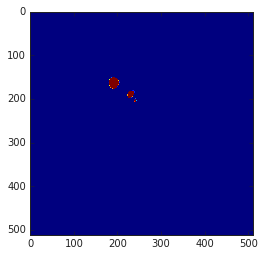

In [72]:
index = 985
show_png(index,kind="M")

(128, 128)


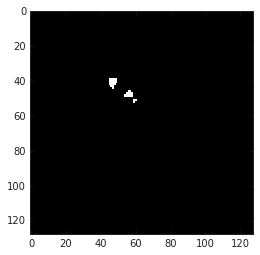

In [25]:
mk = read_png(index,kind="M")
mk = mk.astype('uint8')
print(np.shape(mk))
plt.imshow(mk,"gray")

In [26]:
# Examine Mask channels and values

# def channels_info(channels):
#     for c in channels:
#         print(str(np.unique(c))[:100])
#         print(np.shape(c),end="\n\n")

# def get_channels(img):
#     channels_num = np.shape(mk)[2]
#     return [img[:,:,i] for i in range(0,channels_num)]

# channels_info(get_channels(mk))

In [27]:
# mk[mk > 0] = 1
# channels_info(get_channels(mk))

In [28]:
# # Remove the 1s channel
# mk = mk[:,:,:3]
# channels_info(get_channels(mk))

In [29]:
# mk = np.max(mk,axis=2)# Combine all the three channels

# Resize PNG

In [30]:
(PATH/'train_masks-128').mkdir(exist_ok=True)
(PATH/'train-128').mkdir(exist_ok=True)

In [31]:
!ls {PATH}

512Auto.masks.pngs.tar.gz  nifti-512	 train-512-NP
512Auto.pngs.tar.gz	   stls.ours	 train_masks-128
bad-ct-512		   tmp		 train_masks-128-3c
bad-mask-512		   train-128	 train_masks-128-NP
ct-512			   train-128-3c  train_masks-512
mask-512		   train-128-NP  train_masks-512-1ch
models			   train-512	 train_masks-512-NP


In [35]:
# Will return indexs of nonempty masks
def find_nonempty_masks(files):
    for i in range(0,len(files)):
        fn = files[i]
        str(fn)
        mk = mpimg.imread(str(fn))
        mk = mk[:,:,:3]
        mk = mk.astype('uint8')
        if np.sum(mk) > 0:
            print(i,end=", ",)

# find the nonempty masks in the first 100 files
#files = list((PATH/'train_masks-512').iterdir())[:100] 
#find_nonempty_masks(files)

In [37]:
def clean_mask(fn):
    mk = mpimg.imread(str(fn)) # read the file as a np.array
    mk = mk[:,:,:3] # Remove the ones channel
    mk = mk.astype('uint8') # change type
    mk[mk > 0] = 255 # none zero is 255. (Binary classes)
    mk = np.max(mk,axis=2) # Combine all the three channels in one channel
    return Image.fromarray(mk)# return as an image object

# plt.imshow(mk*255,"binary")

# fn = list((PATH/'train_masks-512').iterdir())[98]
# clean_mask(fn)

In [36]:
def resize_mask(fn):
    clean_mask(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

# files = list((PATH/'train_masks-512').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [36]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

# files = list((PATH/'train-512').iterdir())
# with ThreadPoolExecutor(6) as e: e.map(resize_img, files)

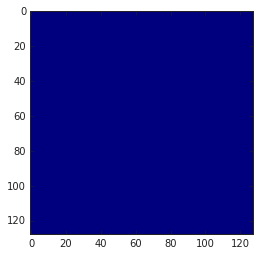

In [37]:
fn = files[99]
m = plt.imread(str((fn.parent.parent)/'train_masks-128'/fn.name))
plt.imshow(m)

# Remove misleading images with wrong masks

In [38]:
def get_dicom_files_names_from_pngs():
    return np.unique([re.sub(r"_.*", "", x.parts[-1]) for x in (PATH/'train_masks-512/').rglob("*.png")])

files_ids = get_dicom_files_names_from_pngs()
files_ids

array(['A012.mask', 'A013.mask', 'A015.mask', 'A016.mask', 'A017.mask', 'A018.mask', 'A019.mask',
       'A022.mask', 'A023.mask', 'A024.mask', 'A025.mask', 'A027.mask', 'A029.mask', 'A031.mask',
       'A032.mask', 'A033.mask', 'A036.mask', 'A040.mask', 'A041.mask', 'A042.mask', 'A043.mask',
       'A046.mask', 'A047.mask', 'A049.mask', 'A050.mask', 'A051.mask', 'A054.mask', 'A057.mask',
       'A064.mask', 'A065.mask', 'A066.mask', 'A067.mask', 'A071.mask', 'A072.mask', 'A074.mask',
       'A075.mask', 'A077.mask', 'A080.mask', 'A081.mask', 'A082.mask', 'A083.mask', 'A084.mask',
       'A086.mask', 'A087.mask', 'A088.mask', 'A089.mask', 'A091.mask', 'A092.mask', 'A093.mask',
       'A100.mask', 'A103.mask', 'A107.mask', 'A109.mask'], dtype='<U9')

In [39]:
mask_tensor = mask_as_tensor(10)

# Observation: In the most if not all of the dicom files
# labels are missing for the first slices even the artery is clearly there
# This function returns from which slice the leabling started
# For mask #6 = 54
# For mask #10 = 124
# Every mask before this number is misleading
# @tensor (512x512)
def get_first_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last):
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i
        
get_first_nonempty_slice_index(mask_tensor)

124

In [38]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

# Balancing dataset

In [73]:

def split_empty_nonempty_datapoints(files):
    empty = np.array([]).astype('uint8')
    nonempty = np.array([]).astype('uint8')
    for idx,f in enumerate(files):
        mk = mpimg.imread(str(f))
        if np.argmax(mk) > 0:
            nonempty = np.append(nonempty,idx)
        else:
            empty = np.append(empty,idx)
    return empty,nonempty

# # Will return indexs of nonempty masks
# def find_nonempty_masks(files):
#     for i in range(0,len(files)):
#         fn = files[i]
#         mk = mpimg.imread(str(fn))
#         mk = mk[:,:,:3]
#         mk = mk.astype('uint8')
#         if np.sum(mk) > 0:
#             print(i,end=", ",)


files = list((MASK_128).iterdir())
empty,nonempty = split_empty_nonempty_datapoints(files)

NameError: name 'MASK_128' is not defined

In [39]:
#print("empty:",len(empty),"nonempty:",len(nonempty))
empty_subset = np.random.choice(empty,len(nonempty)) # choice random subset from empty that equals to the siez of nonempty
balanced_idx = np.append(nonempty,empty_subset)
np.random.shuffle(balanced_idx)
balanced_idx

array([20248,  7941,  1490, ..., 11167, 21817, 19305])

In [40]:
print("balanced:",len(balanced_idx),"empty:",len(empty),"nonempty:",len(nonempty))

balanced: 15490 empty: 17677 nonempty: 7745


# Dataset

In [75]:
# TRAIN_DN = TRAIN_128_3C
# MASKS_DN = MASK_128

TRAIN_DN = TRAIN_128
MASKS_DN = MASK_128
sz = 128
bs = 64

In [58]:
def get_png_paths(source_dir):
    return sorted(gb.glob(f"{PATH/source_dir}/*.png"))

# Shows img and mask side by side
def browse_png_and_mask(original_dir,mask_dir,dicom_num):
    
    original_pngs = get_png_paths(original_dir)
    mask_pngs = get_png_paths(mask_dir)
    
    last = len(original_pngs)-1

    def show_png_(num):
        f = plt.figure(figsize=(10,10))
        f.add_subplot(1,2, 1)
        print(original_pngs[num])
        print(mask_pngs[num])
        plt.imshow(plt.imread(original_pngs[num]))
        f.add_subplot(1,2, 2)
        print(mask_pngs[num])
        plt.imshow(plt.imread(mask_pngs[num]))

    interact(show_png_, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout))

browse_png_and_mask(str(PATH/TRAIN_DN),str(PATH/MASKS_DN),0)

TraitError: setting max < min

In [59]:
class MatchedFilesDataset (FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [60]:
#file_names = np.array([f.name for f in (PATH/TRAIN_DN).rglob("*.png")])

In [61]:
x_names = np.array(sorted(list((PATH/TRAIN_DN).iterdir())))
y_names = np.array(sorted(list((PATH/MASKS_DN).iterdir())))

FileNotFoundError: [Errno 2] No such file or directory: '/home/amer/data/aneurysm/train-128'

In [62]:
# Filter a part of the empty masks
x_names = np.take(x_names, balanced_idx)
y_names = np.take(y_names, balanced_idx)

NameError: name 'x_names' is not defined

In [59]:
!ls {x_names[2600]}
!ls {y_names[2600]}

/home/amer/data/aneurysm/train-128/A033_403.png
/home/amer/data/aneurysm/train_masks-128/A033.mask_403.png


In [60]:
val_percentage = int(np.round(len(x_names) * 0.2)) # 20% of data is validation set
val_idxs = list(range(3000))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [39]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            #RandomFlip(tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS),
            RandomZoom(zoom_max=1.1,tfm_y=TfmType.CLASS),
            RandomLighting(0.02, 0.02, tfm_y=TfmType.CLASS)]

In [40]:
f = resnet34

In [55]:
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

NameError: name 'trn_x' is not defined

# Simple upsample

In [46]:
cut,lr_cut = model_meta[f]

def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [47]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [48]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [49]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [50]:
class  UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [51]:
m_base = get_base()

In [52]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [53]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

NameError: name 'md' is not defined

In [54]:
learn.summary()

NameError: name 'learn' is not defined

In [73]:
learn.freeze_to(1)

 83%|████████▎ | 163/196 [00:43<00:08,  3.72it/s, loss=0.679]

Exception ignored in: <bound method tqdm.__del__ of  83%|████████▎ | 163/196 [06:31<01:19,  2.40s/it, loss=0.679]>
Traceback (most recent call last):
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/site-packages/tqdm/_tqdm.py", line 882, in __del__
    self.close()
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1087, in close
    self._decr_instances(self)
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/site-packages/tqdm/_tqdm.py", line 452, in _decr_instances
    cls.monitor.exit()
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/site-packages/tqdm/_monitor.py", line 50, in exit
    self.join()
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


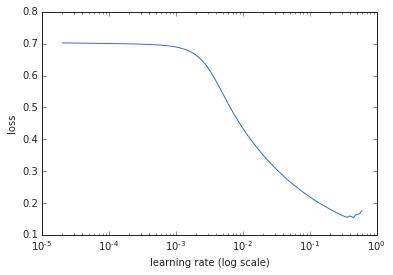

In [425]:
learn.lr_find()
learn.sched.plot()

In [64]:
learn.sched.best

AttributeError: 'NoneType' object has no attribute 'best'

In [65]:
1e-1

0.1

In [73]:
lr=4e-2
wd=8e-7

lrs = np.array([lr/100,lr/10,lr])

learn.fit(lr,1, wds=wd, cycle_len=10,use_clr=(45,10))

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.010433   0.005104   0.99906    0.0       
    1      0.010266   0.004781   0.99906    0.0               
    2      0.010427   0.005232   0.999057   0.000362          
    3      0.010505   0.004608   0.999057   0.020885           
    4      0.010691   0.005136   0.999058   0.005259          
    5      0.010321   0.005451   0.998937   0.07599           
    6      0.009901   0.004756   0.999053   0.011055           
    7      0.009624   0.004373   0.999057   0.009488           
    8      0.009435   0.004305   0.999058   0.008346           
    9      0.009726   0.004313   0.999058   0.015722           



[array([0.00431]), 0.9990579220453898, 0.01572177478945585]

In [262]:
learn.save('128')

In [29]:
learn.load('82')

NameError: name 'learn' is not defined

In [75]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))


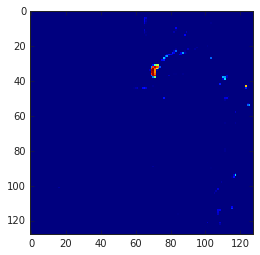

In [76]:
idx = 80
train_128 = np.array(sorted(list(TRAIN_DN.iterdir())))
plt.imshow(plt.imread(str(train_128[idx])))

x,y = next(iter(md.val_dl))

In [77]:
np.shape(x)

torch.Size([64, 3, 128, 128])

In [273]:
#V(plt.imread(str(train_128[idx])))

In [78]:
learn.predict(V(plt.imread(str(TRAIN_DN[idx]))))

TypeError: 'PosixPath' object does not support indexing

In [79]:
def pshow(i):
    show_img(y[i]);
    show_img(py[i]>0)

interact(pshow, i=widgets.IntSlider(min=0,max=len(py)-1,step=1,layout=layout))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='90%'), max=63), Output()), _dom…

<function __main__.pshow(i)>

# UNet

In [284]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [285]:
m_base = get_base()

In [286]:
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [287]:
#[o.features.size() for o in m.sfs]

In [288]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.097433   492.646858 0.053243   0.000994  


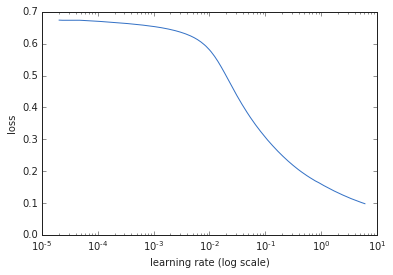

In [289]:
learn.lr_find()
learn.sched.plot()

In [290]:
learn.sched.best

0.0939633168449693

In [295]:
lr=9e-1
wd=1e-7

lrs = np.array([lr/10,lr/10,lr])

In [297]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_swa=(4,2))

epoch      trn_loss   val_loss   <lambda>   dice       swa_loss   swa_<lambda> swa_dice   
    0      0.38454    0.660883   0.998965   0.0        0.719887   0.998965   0.0       
    1      0.611526   2.836181   0.998647   0.244978         
    2      0.22699    0.045254   0.998972   0.10949          
    3      0.101941   0.029622   0.9981     0.25942           
    4      0.026084   0.019399   0.999092   0.46231           


KeyboardInterrupt: 

# 512 x 512 Resolution 

In [112]:
train_masks_512_1ch ='train_masks-512-1ch'
(PATH/train_masks_512_1ch).mkdir(exist_ok=True)
!ls -d {str(PATH/train_masks_512_1ch)}

/home/amer/data/aneurysm/train_masks-512-1ch


# Convert 512 masks into one channel masks with binary (0,255)

In [117]:
# def clean_mask_512(fn):
#     clean_mask(fn).save((fn.parent.parent)/train_masks_512_1ch/fn.name)

# files = list((PATH/'train_masks-512').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(clean_mask_512, files)

# 512x512

In [330]:
TRAIN_DN = TRAIN_512
MASKS_DN = MASK_512

In [319]:
sz=512
bs=8

In [320]:
x_names = np.array(sorted(list((PATH/TRAIN_DN).iterdir())))
y_names = np.array(sorted(list((PATH/MASKS_DN).iterdir())))

In [321]:
# Filter a part of the empty masks
x_names = np.take(x_names, balanced_idx)
y_names = np.take(y_names, balanced_idx)

In [322]:
val_idxs = list(range(len(balanced_idx)))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [390]:
f = resnet34
cut,lr_cut = model_meta[f]

def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [391]:
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [392]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [393]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

Exception ignored in: <bound method tqdm.__del__ of   0%|          | 0/196 [01:59<?, ?it/s]>
Traceback (most recent call last):
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/site-packages/tqdm/_tqdm.py", line 882, in __del__
    self.close()
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1087, in close
    self._decr_instances(self)
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/site-packages/tqdm/_tqdm.py", line 439, in _decr_instances
    cls._instances.remove(instance)
  File "/home/amer/anaconda3/envs/fast/lib/python3.6/_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x7f0865cb2c78; to 'tqdm' at 0x7f086b23aa58>


In [394]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [395]:
learn.freeze_to(1)

In [396]:
learn.lr_find()
learn.sched.plot()

 23%|██▎       | 45/196 [00:13<00:45,  3.34it/s, loss=0.773]

KeyboardInterrupt: 

In [398]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

 99%|█████████▉| 195/196 [00:44<00:00,  4.43it/s, loss=0.00719]

KeyboardInterrupt: 

In [ ]:
np.random.RandomState(None)